In [9]:
import numpy as np
import torch.nn as nn
import torch
from os import listdir
from os.path import join
import torch.optim as optim
import math
import sys
from PIL import Image
from torch.autograd import Variable
from tqdm import tqdm_notebook as tqdm
import warnings
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
warnings.filterwarnings("ignore")
random.seed(2022)
from skimage.color import rgb2ycbcr
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize,Normalize

In [10]:
class imgDataset(Dataset):
    def __init__(self, hr_dir,crop_size,UPSCALE_FACTOR):
        super(imgDataset, self).__init__()
        
        crop_size = crop_size - (crop_size % UPSCALE_FACTOR)
        self.filenames = [join(hr_dir, x) for x in listdir(hr_dir)]
        self.lr_transform = Compose([
        ToPILImage(),
        Resize(crop_size // UPSCALE_FACTOR, interpolation=Image.BICUBIC),
        ToTensor()
    ])
        self.hr_transform = Compose([
        RandomCrop(crop_size),
        ToTensor(),
    ])


    def __getitem__(self, index):
        hr_image = self.hr_transform(Image.open(self.filenames[index]))
        lr_image = self.lr_transform(hr_image)
        return lr_image, hr_image
    def __len__(self):
        return len(self.filenames)


In [34]:
def u(s, a):
    if (abs(s) >= 0) & (abs(s) <= 1):
        return (a+2)*(abs(s)**3)-(a+3)*(abs(s)**2)+1
    elif (abs(s) > 1) & (abs(s) <= 2):
        return a*(abs(s)**3)-(5*a)*(abs(s)**2)+(8*a)*abs(s)-4*a
    return 0
  
  
# Padding
def padding(img, H, W, C):
    zimg = np.zeros((H+4, W+4, C))
    zimg[2:H+2, 2:W+2, :C] = img
      
    # Pad the first/last two col and row
    zimg[2:H+2, 0:2, :C] = img[:, 0:1, :C]
    zimg[H+2:H+4, 2:W+2, :] = img[H-1:H, :, :]
    zimg[2:H+2, W+2:W+4, :] = img[:, W-1:W, :]
    zimg[0:2, 2:W+2, :C] = img[0:1, :, :C]
      
    # Pad the missing eight points
    zimg[0:2, 0:2, :C] = img[0, 0, :C]
    zimg[H+2:H+4, 0:2, :C] = img[H-1, 0, :C]
    zimg[H+2:H+4, W+2:W+4, :C] = img[H-1, W-1, :C]
    zimg[0:2, W+2:W+4, :C] = img[0, W-1, :C]
    return zimg
  
  
# Bicubic operation
def bicubic(img, ratio, a):
    
    # Get image size
    H,W,C = img.shape
    #print(C,H,W)
    # Here H = Height, W = weight,
    # C = Number of channels if the 
    # image is coloured.
    img = padding(img, H, W, C)
      
    # Create new image
    dH = math.floor(H*ratio)
    dW = math.floor(W*ratio)
  
    # Converting into matrix
    dst = np.zeros((dH, dW, 3))  
    # np.zeroes generates a matrix 
    # consisting only of zeroes
    # Here we initialize our answer 
    # (dst) as zero
  
    h = 1/ratio
  
#     print('Start bicubic interpolation')
#     print('It will take a little while...')
    inc = 0
      
    for c in range(C):
        for j in range(dH):
            for i in range(dW):
                
                # Getting the coordinates of the
                # nearby values
                x, y = i * h + 2, j * h + 2
  
                x1 = 1 + x - math.floor(x)
                x2 = x - math.floor(x)
                x3 = math.floor(x) + 1 - x
                x4 = math.floor(x) + 2 - x
  
                y1 = 1 + y - math.floor(y)
                y2 = y - math.floor(y)
                y3 = math.floor(y) + 1 - y
                y4 = math.floor(y) + 2 - y
                  
                # Considering all nearby 16 values
                mat_l = np.matrix([[u(x1, a), u(x2, a), u(x3, a), u(x4, a)]])
                mat_m = np.matrix([[img[int(y-y1), int(x-x1), c],
                                    img[int(y-y2), int(x-x1), c],
                                    img[int(y+y3), int(x-x1), c],
                                    img[int(y+y4), int(x-x1), c]],
                                   [img[int(y-y1), int(x-x2), c],
                                    img[int(y-y2), int(x-x2), c],
                                    img[int(y+y3), int(x-x2), c],
                                    img[int(y+y4), int(x-x2), c]],
                                   [img[int(y-y1), int(x+x3), c],
                                    img[int(y-y2), int(x+x3), c],
                                    img[int(y+y3), int(x+x3), c],
                                    img[int(y+y4), int(x+x3), c]],
                                   [img[int(y-y1), int(x+x4), c],
                                    img[int(y-y2), int(x+x4), c],
                                    img[int(y+y3), int(x+x4), c],
                                    img[int(y+y4), int(x+x4), c]]])
                mat_r = np.matrix(
                    [[u(y1, a)], [u(y2, a)], [u(y3, a)], [u(y4, a)]])
                  
                # Here the dot function is used to get 
                # the dot product of 2 matrices
                
               
                dst[j, i, c] = np.dot(np.dot(mat_l, mat_m), mat_r)
  
    # If there is an error message, it
    # directly goes to stderr
    sys.stderr.write('\n')
      
    # Flushing the buffer
    sys.stderr.flush()
    return dst
  

  0%|          | 0/80 [00:00<?, ?it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers

0.91136515 2
31.509707426803335 2


  0%|          | 0/80 [00:00<?, ?it/s]



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for intege

0.81330806 3
27.416035721225093 3


  0%|          | 0/80 [00:00<?, ?it/s]



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integer

0.7922663 4
27.108976251577644 4


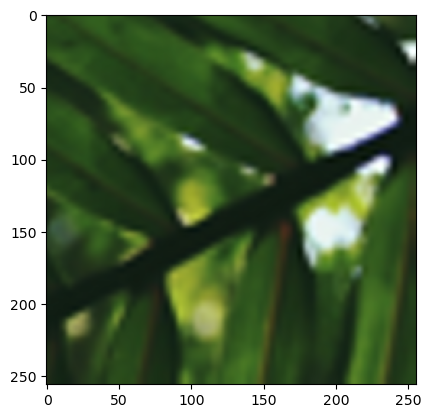

In [35]:
Tensor = torch.cuda.FloatTensor if torch.cuda else torch.Tensor
device = 'cuda' if torch.cuda.is_available() else 'cpu'
for i in [2,3,4]:
    test_dataset = imgDataset("DIV2K_test_HR", 256,i)
    testloader = DataLoader(test_dataset, batch_size=1, num_workers=0, shuffle=True)
    ssim_list = []
    psnr_list = []
    tqdm_bar = tqdm(testloader)
    for lrImg, hrImg in tqdm_bar:

        realImg = Variable(hrImg.type(Tensor))
        realImg = realImg.to( device)
        fakeImg = Variable(lrImg.type(Tensor))
        fakeImg = fakeImg.to(device)
        
        imgplot = plt.imshow(np.moveaxis(np.squeeze(realImg[0].cpu().detach().numpy()), 0, -1))
#         plt.show()
        imgplot = plt.imshow(np.moveaxis(np.squeeze(fakeImg[0].cpu().detach().numpy()), 0, -1))
#         plt.show()
        #print(np.squeeze(realImg.cpu().detach().numpy()).T.shape,"2")
        
        fakeImg = bicubic(np.moveaxis(np.squeeze(fakeImg.cpu().detach().numpy()), 0, -1), i, -0.5)
        imgplot = plt.imshow(fakeImg)
#         plt.show()
        #print(fakeImg.shape)
        image1 = np.moveaxis(np.squeeze(realImg.cpu().detach().numpy()), 0, -1)
        image2 = fakeImg

#         print(image1.shape,"1")
#         print(image2.shape,"2")
        
        ssim_list.append(ssim(
            image1,
            image2,
            win_size =3,
            gaussian_weights=True,
            multichannel = True
        ))
        psnr_list.append(psnr(
            image1, 
            image2,
        ))
    print(np.mean(ssim_list),str(i))
    print(np.mean(psnr_list),str(i))

In [14]:
import numpy as np  
from skimage.metrics import structural_similarity

img1 = np.random.randint(0, 255, size=(200, 200, 3)).astype(np.float32)
img2 = np.random.randint(0, 255, size=(200, 200, 3)).astype(np.float32)

ssim_score = structural_similarity(img1, img2, multichannel=True) #score: 0.0018769083894301646

ssim_score = structural_similarity(img1, img1, multichannel=True) #score: 1.0

In [18]:
fakeImg.shape

(256, 256, 3)

In [19]:
np.squeeze(realImg.cpu().detach().numpy()).T.shape

(256, 256, 3)

In [27]:
structural_similarity(np.squeeze(realImg.cpu().detach().numpy()).T, fakeImg, multichannel=True)

0.41479298

In [28]:
ssim_list

[0.9999923]